# Librerias y funciones previas

Comencemos cargando las librerías que usaremos a lo largo del trabajo, y definiendo todas las funciones necesarias.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Las próximas funciones las obtuvimos del whitepaper de Balancer (o de la propia dev doc del protocolo). A saber

- OutGivenIn: Devuelve la cantidad A_o (o = out) del token j = 1-i que obtendríamos si metiéramos al pool A_i (i = in) unidades del token i.
- InGivenOut: Devuelve la cantidad A_i del token j = 1-i que habría que meter al pool para obtener A_o unidades del token i.
- InGivenPrice: Devuelve la cantidad del token j = 1-i que habría que meter al pool si queremos cambiar el precio del pool P_pool a un nuevo precio P_new, metiendo el token i.

In [ ]:
def OutGivenIn(balance, A_i, i):
  '''
  P_ETH = balance[0] / balance[1]
  i = 0 quiere decir que meto USDC
  '''
  B_i = balance[i]
  B_o = balance[i-1]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_o = B_o * (1-B_i/(B_i+A_i))
  return A_o

def InGivenOut(balance, A_o, i):
  B_i = balance[i]
  B_o = balance[i-1]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_i = B_i * (B_o/(B_o-A_o)-1)
  return A_i 

def InGivenPrice(balance, P_new, i):
  P_pool = balance[0] / balance[1]
  B_i = balance[i]
  # if i==0:
  #   B_i = balance[0]
  #   B_o = balance[1]
  # else:
  #   B_i = balance[1]
  #   B_o = balance[0]
  A_i = B_i * ((P_new/P_pool)**(1/2)-1)
  return A_i

La idea para emular los cambios en los balances del pool va a ser la siguiente:
- Dado un nuevo precio de mercado (de la data historica) vamos a comparar el precio del pool con el precio de mercado para saber cuál es más alto y ver qué moneda (i=0 USDC, i=1 wETH) debemos ingresar al pool para cambiar el precio relativo. Para eso usaremos la funcion InGivenPrice;
- Sabiendo la cantidad $A_i$ del token $i$ que debemos ingresar al pool, utilizaremos la función OutGivenIn para saber cuántas unidades $A_o$ del token o recibiremos por el swap;
- Finalmente teniendo ahora sí cuántas unidades del token i metimos al pool y cuántas unidades del token o sacamos del pool, podremos actualizar los balances.


Definimos entonces las siguientes funciones

- variacion_balances(balance_nuevo, balance_anterior): Devuelve la variacion como porcentaje (pcg) y en unidades, entre los dos balances que le pasemos. Usaremos esta función para calcular la variacion de los balances y aplicar estos cambios a nuestras tenencias. Otra forma sería directamente quedarnos con el % de nuestra participación en el pool para cada balance simulado.
- new_balance(P_new, balance_anterior): Devuelve el nuevo balance del pool dados el nuevo precio de mercado y el balance anterior. Esta función encierra la lógica que describimos en el párrafo anterior.
[Ej: Si ETH se valoriza en el mercado, entonces el pool tiene que reducir el balance de ETH. Con lo cual uno podría calcular cuánto USDC hay que meter para cambiar P_pool a P_new (InGivenPrice) y luego para ese A_i, calcular cuántos A_o ETH recibiría por esos A_i USDC (OutGivenIn). Finalmente, sumamos A_i al balance de USDC, restamos A_o al balance de ETH y tenemos el nuevo balance]

In [ ]:
def variacion_balances(balance_nuevo, balance_anterior):
  r_USDC = balance_nuevo[0] / balance_anterior[0] -1
  r_ETH = balance_nuevo[1] / balance_anterior[1] -1
  return {'pcg': [r_USDC, r_ETH],
          'unidades': [balance_nuevo[0]-balance_anterior[0], balance_nuevo[1]-balance_anterior[1]]}
def new_balance(P_new, balance_anterior):
  P_pool = balance_anterior[0] / balance_anterior[1]
  if P_pool < P_new: # ETH se apreció en el mercado, entonces tiene que bajar su balance y subir el de USDC
    A_i = InGivenPrice(balance_anterior, P_new, 0)
    A_o = OutGivenIn(balance_anterior, A_i, 0)
    return [balance_anterior[0] + abs(A_i), balance_anterior[1] - abs(A_o)]
  else: # si ETH se deprecia en el mercado, tiene que subir su balance
    A_i = InGivenPrice(balance_anterior, P_new, 1)
    A_o = OutGivenIn(balance_anterior, A_i, 1)
    return [balance_anterior[0] - abs(A_o), balance_anterior[1] + abs(A_i)]

Por último, definimos las funciones de Impermanent Loss como % y en USD, en términos de $R=\frac{P}{P_0}$ y de $P$, dadas por

\begin{align*}
  IL_{\%}(R) &= \frac{2\sqrt{R}}{R+1} -1 \Rightarrow IL_{USD}(R) = IL_{\%}(R)*V_{Hold};\\
  IL_{\%}(P) &= 2\sqrt{P_0}\frac{\sqrt{P}}{P+P_0}-1 \Rightarrow IL_{USD}(P) = IL_{\%}(P)*V_{Hold};\\ 
\end{align*}

Hay otra escritura posible para $IL_{USD}(P)$ que sale usando

\begin{align*}
  V_P &= 2\sqrt{kP} = 2\sqrt{kP_0}\sqrt{\frac{P}{P_0}} = V_P^0\sqrt{\frac{P}{P_0}},\\
  V_H &= \sqrt{kP_0}\left(\frac{P}{P_0}+1\right) = 2\sqrt{kP_0}\frac{1}{2}\left(\frac{P}{P_0}+1\right)=\frac{V_H^0}{2}\left(\frac{P}{P_0}+1\right).
\end{align*}

Notar que en las últimas identidades estamos usando $k(t)=k(0)$, que podría no ser cierto (Ver sección ¿Es lo mismo calcular IL como la diferencia entre V_P y V_H que tomar las formulas? NO!).

Nos queda entonces

$$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right).$$

**Observación** 

Como la idea es hedgearse contra el cambio en la IL respecto de cambios en el precio, debemos expresarla como función de $P$. Además, nos interesa manejar esa pérdida en términos de USDC y no como un ratio.

In [ ]:
def IL_R(R):
  return 2 * R**(1/2)/(R+1)-1
def IL_P(P):
  # return IL_R(P/P_entry)
  return 2 * (P_entry)**(1/2) * P**(1/2)/(P+P_entry)-1
def IL_R_in_usd(R):
  P = R * P_entry
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  return IL_R(R) * V_hold
def IL_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  # V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  # return IL_R_in_usd(P/P_entry)
  return IL_P(P) * V_hold
  # return V_hold_0 * ((P/P_entry)**(1/2) - 1/2 - P/(2*P_entry))


Podemos entonces calcular la derivada de IL

\begin{align*}
  \frac{\partial}{\partial R}IL_{\%}(R) &= \frac{1-R}{\sqrt{R}(R+1)^2}; \
  \frac{\partial}{\partial P}IL_{\%}(P) = \sqrt{P_0}\frac{P_0-P}{\sqrt{P}(P+P_0)^2} \\ 
  \Rightarrow \frac{\partial}{\partial P}IL_{USD}(P) &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * \frac{\partial}{\partial P}V_{Hold}\\
  &= \frac{\partial}{\partial P}IL_{\%}(P) * V_{Hold} + IL_{\%}(P) * b,
\end{align*}
donde en la última identidad usamod $V_{Hold} = tenencias\_inicial[0] + tenencias\_inicial[1] * P =: a + b*P$.

Equivalentemente, si usamos $$IL_{USD}(P) = V_P - V_H = V_H^0\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right),$$
nos queda
$$\frac{\partial}{\partial P}IL_{USD}(P) = \frac{V^0_H}{2P_0}\left(\sqrt{\frac{P_0}{P}}-1\right).$$

In [ ]:
#
def IL_derivada_R(R):
  return (1-R) / (R**(1/2)*(R+1)**2)
def IL_derivada_P(P):
  return IL_derivada_R(P/P_entry) / P_entry
  # return (P_entry)**(1/2)*(P_entry-P)/(P**(1/2)*(P+P_entry)**2)
def IL_derivada_P_in_usd(P):
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * P
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * P_entry
  return IL_derivada_P(P) * V_hold + IL_P(P) * tenencias_inicial[1]
  # return V_hold_0/(2*P_entry) * ((P_entry/P)**(1/2) - 1)

Agregamos también las fórmulas incorporando fees. Sean $fee=\tau$, $\phi = 1-\tau$, $P:=p^{bid^1}$ y $P_0:=p^{bid^0}$. Sabiendo que $p^b = \phi P_{Y|X} = \phi \frac{y}{x}$, $R=\frac{P_{Y|X}}{P^0_{Y|X}}=\frac{p^b}{p^b_0}$ y que $V_{Hold} = a+b*p^b$, tenemos

\begin{align*}
  IL^{fee}_{\%}(R) &= \sqrt{R}\frac{1+\phi}{\phi R+1} -1 \Rightarrow \frac{\partial}{\partial R}IL^{fee}_{\%}(R) = \frac{1+\phi}{(1+\phi R)^2}\frac{1-\phi R}{2\sqrt{R}};\\
  IL^{fee}_{\%}(P) &= \sqrt{PP_0}\frac{1+\phi}{P_0+\phi P}-1 \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{\%}(P) = \frac{1+\phi}{2}\sqrt{\frac{P_0}{P}}\frac{P_0-\phi P}{(P_0+\phi P)^2};\\ 
  IL^{fee}_{USD}(P) &= IL^{fee}_{\%}(P)*V_{Hold} \text{ una forma} \\
  &= \frac{V_H^0}{2}\left(\sqrt{\frac{P}{P_0}}\frac{1+\phi}{\phi}-\frac{P_0+\phi P}{P_0\sqrt{\phi}}\right) \text{ otra forma} \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{USD}(P) = \frac{V_H^0}{2P_0}\left(\frac{1}{2}\sqrt{\frac{P_0}{P}}\frac{1+\phi}{\phi}-\sqrt{\phi}\right).
\end{align*}

In [ ]:
def IL_R_fee(R,fee):
  phi = 1-fee
  return R**(1/2)*(1+phi)/(1+R*phi)-1
def IL_P_fee(P,fee):
  phi = 1-fee
  return IL_R_fee(P/P_entry,fee)
  # return (P*P_entry)**(1/2)*(1+phi)/(P_entry+phi*P)-1
def IL_P_in_usd_fee(P,fee):
  phi = 1-fee
  # P = R * P_entry
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  # p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return V_hold_0/2 * ( (p_bid/p_bid_entry)**(1/2) * (1+phi)/phi - (p_bid_entry + phi*p_bid) / (p_bid_entry*phi**(1/2)) )
  # return IL_R_in_usd_fee(P/P_entry,fee)
#
def IL_derivada_R_fee(R, fee):
  phi = 1-fee
  return (1+phi)/(1+phi*R)**2 * (1-phi*R)/(2*R**(1/2))
def IL_derivada_P_fee(P,fee):
  phi = 1-fee
  p_bid_entry = P_entry * phi
  p_bid = P *  phi
  return IL_derivada_R_fee(P/P_entry, fee) / p_bid_entry
  # return (1+phi)/2 * (p_bid_entry/p_bid)**(1/2) * (p_bid_entry-phi*p_bid)/(p_bid_entry+phi*p_bid)**2
def IL_derivada_P_in_usd_fee(P,fee):
  phi = 1-fee
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return IL_derivada_P_fee(P,fee) * V_hold + IL_P_fee(P, fee) * tenencias_inicial[1] 
  # return V_hold_0/(2*p_bid_entry) * ( 1/2*(p_bid_entry/p_bid)**(1/2) * (1+phi)/phi - phi**(1/2) )

Hacemos algunos plots para chequear que todas las formulaciones son, al menos graficamente, equivalentes.

In [ ]:
R_minus = np.arange(0.01, 1, 0.01)
R_plus = np.arange(1, 10, 0.01)

In [ ]:
# fig, axs = plt.subplots(1,1,figsize = (20,7))
# axs.plot(R_minus, IL_R(R_minus), c='red')
# axs.plot(R_plus, IL_R(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P(R_plus*P_entry), c='blue')
# axs.plot(R_minus, IL_R_in_usd(R_minus), c='red')
# axs.plot(R_plus, IL_R_in_usd(R_plus), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd(R_minus*P_entry), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs.plot(R_minus, IL_R_fee(R_minus, fee), c='red')
# axs.plot(R_plus, IL_R_fee(R_plus, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_fee(R_plus*P_entry, fee), c='blue')
# axs.plot(R_minus*P_entry, IL_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs.plot(R_plus*P_entry, IL_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

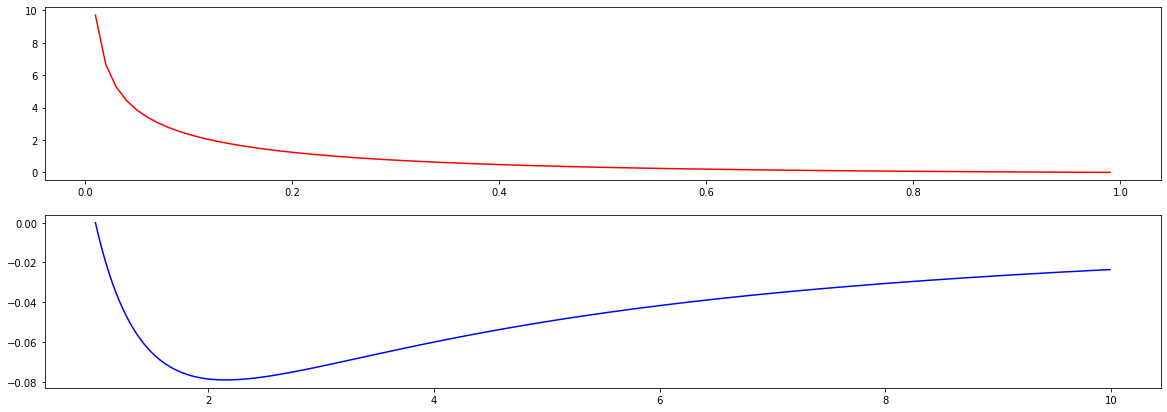

In [ ]:
fig, axs = plt.subplots(2,1,figsize = (20,7))
axs[0].plot(R_minus, IL_derivada_R(R_minus), c='red')
axs[1].plot(R_plus, IL_derivada_R(R_plus), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P(R_plus*P_entry), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd(R_minus*P_entry), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd(R_plus*P_entry), c='blue')
# with fees
# fee = 0.00075
# axs[0].plot(R_minus, IL_derivada_R_fee(R_minus, fee), c='red')
# axs[1].plot(R_plus, IL_derivada_R_fee(R_plus, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_fee(R_plus*P_entry, fee), c='blue')
# axs[0].plot(R_minus*P_entry, IL_derivada_P_in_usd_fee(R_minus*P_entry, fee), c='red')
# axs[1].plot(R_plus*P_entry, IL_derivada_P_in_usd_fee(R_plus*P_entry, fee), c='blue')

# Datos historicos de ETH

En esta sección armamos una función para traer datos históricos de Binance para varias frecuencias temporales. Notar que seteamos initial_date = '31 Mar 2021' pero uno puede poner la fecha de inicio que desee.

In [ ]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 288 kB 11.9 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 112 kB 46.0 MB/s 
     |████████████████████████████████| 271 kB 39.9 MB/s 
     |████████████████████████████████| 144 kB 48.2 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 749 kB 34.0 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = '9zFIgetckRO80d4RciWs8jc4XSwAMEnFIuwVhAoaYIstQ9RWlfqiV6zcAGu0Ta8R'    #Enter your own API-key here
binance_api_secret = 'Uu8vtNEmH1PPDPDchX51jivxBENEbNwDmDcQrnhPJBJwFcbqjnvxL2MeQJuTc4Kg' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}

batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

# initial_date = '1 Jan 2017'
initial_date = '31 Mar 2021'
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime(initial_date, '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime(initial_date, '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


Nos quedamos con datos históricos para ETHUSDC con frecuencia de 5m.

In [ ]:
# lista = ["ETHUSDC"]

# BTC ETH MATIC UNI COMP AAVE YFI CRV MKR LINK KP3R SFI SUSHI 1INCH CAKE 
symbol = "ETHUSDC"
# Frecuencia: 1m, 5m, 10m, 15m, 1h, 1d, 1m
freq = "5m"

# Descarga de datos
ETH_historico = get_all_binance(symbol, freq, save = True)

All caught up..!


In [ ]:
len(ETH_historico)

133357

In [ ]:
ETH_historico

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2021-03-31 00:00:00,1841.29000000,1845.35000000,1841.12000000,1845.35000000,13.45650000,1617149099999,24811.47621960,39,4.46207000,8228.10868710,0
2021-03-31 00:05:00,1844.39000000,1847.08000000,1843.99000000,1846.29000000,54.69818000,1617149399999,100898.41600010,50,18.71127000,34521.30106140,0
2021-03-31 00:10:00,1845.54000000,1849.53000000,1845.54000000,1848.96000000,10.56434000,1617149699999,19523.84183440,31,6.35202000,11739.72432620,0
2021-03-31 00:15:00,1848.96000000,1850.35000000,1847.50000000,1847.50000000,126.93107000,1617149999999,234808.65135190,117,70.35710000,130155.06817220,0
2021-03-31 00:20:00,1848.12000000,1849.12000000,1846.00000000,1846.00000000,16.03979000,1617150299999,29631.68322550,61,3.04496000,5630.11817930,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-07 14:20:00,1213.69000000,1213.69000000,1207.31000000,1209.55000000,621.63930000,1657203899999,752524.18384600,746,239.77200000,290249.98889700,0
2022-07-07 14:25:00,1208.43000000,1214.21000000,1208.43000000,1212.56000000,518.96480000,1657204199999,628691.56924600,669,230.20170000,278875.84077800,0
2022-07-07 14:30:00,1212.28000000,1218.13000000,1211.72000000,1216.89000000,945.09250000,1657204499999,1148458.19510400,1073,356.78150000,433576.84903200,0


# Simulated Paths


Dados $\mu,\sigma,S_0$ los parámetros asociados al drift, volatilidad y dato inicial estimados de los datos, definimos el movimiento browniano geométrico asociado a ETH como el proceso estocástico a tiempo continuo $\{S_t\}_{t\geq 0}$ que satisface la ecuación diferencial estocástica
$$dS_t=\mu S_t dt + \sigma S_t dW_t,$$
para $W$ un movimiento browniano estándar.

Una formulación equivalente para $S_t$ es

$$S_t=S_0\exp{\left(\left(\mu-\frac{\sigma^2}{2}\right)t+\sigma W_t\right)}, \ t\geq 0.$$

In [ ]:
ETH = ETH_historico[2000:][['close']]
for i in range(len(ETH)):
  ETH['close'][i] = float(ETH['close'][i])

In [ ]:
ETH['close'][0]

2115.15

In [ ]:
# ETH's returns
ETH['Returns']=np.around(ETH['close'].pct_change().dropna(),3)
ETH['std21']=ETH['Returns'].rolling(14).std() * np.sqrt(365)

In [ ]:
ETH=ETH.dropna()

Seteamos los parámetros del movimiento browniano.

La variable scen_size es la cantidad de caminos que simularemos. 

El array b, para cada tiempo predicho, guarda un número aleatorio proveniente de una distribución normal estándar. Es decir, es el shock aleatorio que sufre el precio de un tiempo $t$ al siguiente $t+dt$:
$$S_{t+dt}=S_te^{(\mu+\frac{1}{2}\sigma^2)dt+\sigma b(t+dt)}.$$


W, por otro lado, es EL CAMINO COMPLETO. Es decir, incluye los efectos de todos los shocks aleatorios inducidos por el array b. Digamos, $W(M)$ es la suma de los M primeros elementos de b.

Entendemos por
$$drift_k=\mu-\frac{1}{2}\sigma^2 ,\ diffusion_k=\sigma b_k.$$

Por último, recordamos la expresión recurrente que define a $S$:
$$S_k=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)k+\sigma \sum_i^kb_i}=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)t_k+\sigma W_k},$$
para $t_k=k$, $W_k=\sum_i b_i$ y $b_i$ los shocks aleatorios anteriores.

In [ ]:
ETH.index[0]

Timestamp('2021-04-06 22:40:00')

In [ ]:
start_date = ETH.index[0].strftime("%Y-%d-%m %H:%M:%S")

In [ ]:
pd.to_datetime(pred_end_date, 
                 format = "%Y-%d-%m %HH:%M:%S")

ValueError: ignored

In [ ]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# scen_size : number of paths simulated
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = ETH.index[0].strftime("%Y-%d-%m %H:%M:%S")
end_date = ETH.index[len(ETH)-1].strftime("%Y-%d-%m %H:%M:%S")
pred_end_date = '2022-20-01 00:00:00'


S_ETH=ETH['close']
S_ETH['Fecha']=ETH.index
# print(S_eon.head())
# print(S_eon.tail())

returns = ETH['Returns']
# print('Lista de retornos:', returns.tolist())

# Parameter Assignments
So = ETH['close'][len(ETH)-1]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%d-%m %H:%M:%S") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%d-%m %H:%M:%S")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,8) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
# print('\n\n drift--->', drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
# print('\n\n difussion--->', diffusion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: ignored

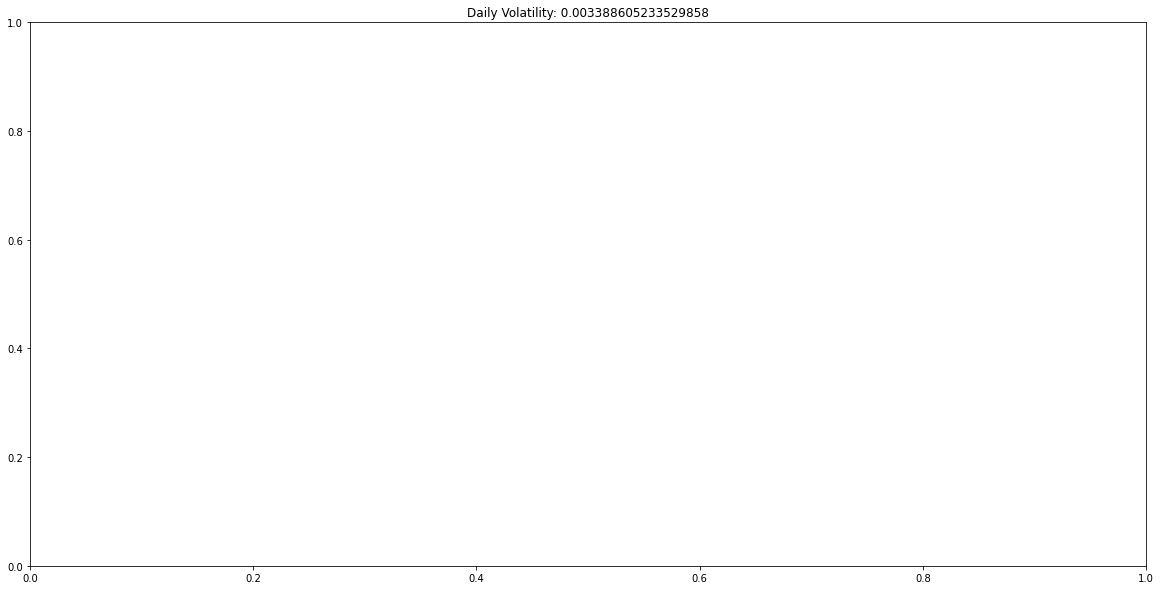

In [ ]:
# Making the predictions
# Usamos la solución explícita de la integral estocástica
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
# print('\n\n S---->', S)

# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_ETH["Fecha"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 8) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, USD')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_ETH["Fecha"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 8) else np.nan).dropna()
           ).reset_index(drop = False)


In [ ]:
aux=pd.DataFrame(S).T.mean(axis=1)
ETH_pred=pd.DataFrame(aux,columns=['Precio'])
ETH_pred['Fecha']=pd.date_range(start = S_ETH["Fecha"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 8) else np.nan).dropna()
ETH_pred=ETH_pred[['Fecha','Precio']]

In [ ]:
ETH_pred.tail(10)